In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
bd = pd.read_csv("data.csv")
print("DataFrame:", bd)

DataFrame:       x          y
0  -2.0 -177.00000
1  -1.8 -124.54208
2  -1.6  -85.42816
3  -1.4  -56.81664
4  -1.2  -36.32672
5  -1.0  -22.00000
6  -0.8  -12.26208
7  -0.6   -5.88416
8  -0.4   -1.94464
9  -0.2    0.20928
10  0.0    1.00000
11  0.2    0.65792
12  0.4   -0.74016
13  0.6   -3.23264
14  0.8   -6.93472
15  1.0  -12.00000
16  1.2  -18.58208
17  1.4  -26.79616
18  1.6  -36.68064
19  1.8  -48.15872
20  2.0  -61.00000


In [3]:
def ini_poblacion(tam_poblacion, num_ind, Imin, Imax):
    poblacion = np.zeros((tam_poblacion, num_ind))
    for i in range(tam_poblacion):
        for j in range(num_ind):
            poblacion[i][j] = np.random.uniform(Imin, Imax)
    return poblacion

In [4]:

def evaluar(poblacion, x, y):
    [r,c] = poblacion.shape 
    n = len(y)
    evaluarciones = np.zeros((n,r))
    fitness = np.zeros(r)
    for i in range(r):
        y_new = (poblacion[i,0] 
                 + poblacion[i,1] * x 
                 + poblacion[i,2] * x ** 2
                 + poblacion[i,3] * x ** 3 
                 + poblacion[i,4] * x ** 4 
                 + poblacion[i,5] * x ** 5)
        y_new = np.array(y_new, dtype=float)
        evaluarciones[:,i] = y_new
        fitness[i] = np.linalg.norm(y - evaluarciones[:,i])
    return fitness

In [5]:
def seleccion(Poblacion, fitness, ps):
    [r, c] = Poblacion.shape 
    indices_ordenados = np.argsort(fitness)
    tam_elite = int(r * ps)
    poblacion_elite = np.zeros((tam_elite, c))
    for i in range(tam_elite):
        poblacion_elite[i,:] = Poblacion[indices_ordenados[i],:]
    
    return poblacion_elite

In [ ]:
def estimacion_distribucion(poblacion_elite):
    dim = poblacion_elite.shape[1]
    media = np.zeros(dim)
    stds = np.zeros(dim)

    for i in range(dim):
        media[i] = np.mean(poblacion_elite[:, i])
        stds[i] = np.std(poblacion_elite[:,i])

    return media, stds

In [7]:
def generar_nueva_poblacion(tam_pob, media, stds): 
    dim = len(media)
    nueva_pob = np.zeros((tam_pob, dim))
    for i in range(tam_pob):
        for j in range(dim):
            nueva_pob[i,j] = np.random.normal(media[j], stds[j])

    return nueva_pob

In [12]:
# Funcion para calcular la media y la stds
def BUMDA_media_stds(pobla_elite, g, Imin, Imax, beta=1.0, eps=1e-8):
    # pobla_elite: poblacion seleccionada (numpy array)
    # g: lista de fitness correspondientes a pobla_elite
    # Imin, Imax: limites del espacio de busqueda
    # beta: parametro de Boltzmann (mayor beta => mayor seleccion)
    # eps: valor pequeño para evitar division por cero
    m, d = pobla_elite.shape

    # transformar fitness en pesos Boltzmann 
    w = np.exp(-beta * np.array(g, dtype=float))
    w_sum = np.sum(w)
    if w_sum == 0:
        w = np.ones_like(w) / len(w)
    else:
        w = w / w_sum

    mu = np.zeros(d)
    sigma = np.zeros(d)

    for j in range(d):
        xj = pobla_elite[:, j]
        mu_j = np.sum(w * xj)               # media ponderada
        var_j = np.sum(w * (xj - mu_j) ** 2)  # varianza ponderada
        sigma_j = np.sqrt(max(var_j, eps))  # evita sigma 0

        # Si sigma muy grande, recortar a rango razonable (basado en Imin,Imax)
        max_sigma = (Imax - Imin) / 2.0
        sigma_j = min(sigma_j, max_sigma)

        mu[j] = mu_j
        sigma[j] = sigma_j


    return mu, sigma

El mejor cromosoma es: [ 1.28427773  3.55950763 -9.11278918  7.89077711 -3.61878128 -0.5513755 ]


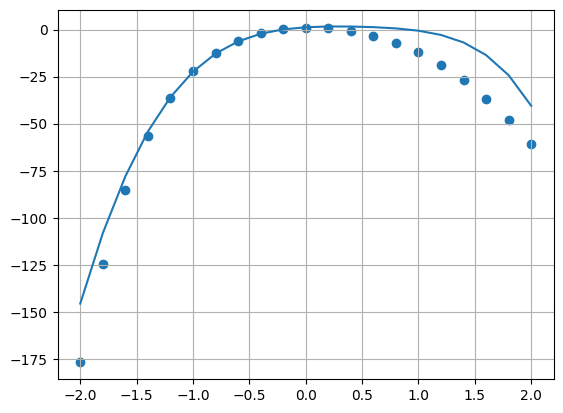

In [ ]:
x = bd["x"]
y = bd["y"]
tam_poblacion = 100
num_ind = 6
generaciones = 100
Imin = -10
Imax = 10
ps = 0.5


P = ini_poblacion(tam_poblacion, num_ind, Imin, Imax)
mejor_solucion = None
mejor_fitness = float('inf')

for k in range(generaciones):
    # 1) Evalúa la población actual
    fitness = evaluar(P, x, y)  # shape (tam_poblacion,)

    # 2) Selección de élite (ps es proporción, por ejemplo 0.5)
    num_elite = max(2, int(ps * tam_poblacion))
    indices_elite = np.argsort(fitness)[:num_elite]
    pobla_elite = P[indices_elite, :]

    # 3) Calcula mu y sigma con BUMDA (boltzmann ponderado sobre fitness de la élite)
    mu, sigma = BUMDA_media_stds(pobla_elite, fitness[indices_elite], Imin, Imax, beta=1.0)

    # 4) Genera nueva población
    P = generar_nueva_poblacion(tam_poblacion, mu, sigma)

    idx_best = np.argmin(fitness)
    if fitness[idx_best] < mejor_fitness:
        mejor_fitness = fitness[idx_best]
        mejor_solucion = P[idx_best].copy()  # copia para seguridad

print(f'El mejor cromosoma es: {mejor_solucion}')
mejor_y = mejor_solucion[0] + mejor_solucion[1] * x + mejor_solucion[2] * x ** 2 + mejor_solucion[3] * x ** 3 + mejor_solucion[4] * x ** 4 + mejor_solucion[5] * x ** 5
x = np.asarray(x, dtype=float)
y = np.asarray(y, dtype=float)
mejor_y = np.asarray(mejor_y, dtype=float)

# Ordena por x antes de trazar la línea
idx = np.argsort(x)
x_ord = x[idx]
mejor_y_ord = mejor_y[idx]

# Grafica: puntos (scatter) y luego la línea con x ordenado
plt.scatter(bd["x"], bd["y"])                # puntos
plt.plot(x_ord, mejor_y_ord)     # línea que ahora sigue x ascendente
plt.grid()
plt.show()